In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
import copy

from nflows.utils import tensor2numpy, create_mid_split_binary_mask
from nflows.distributions import StandardNormal
from nflows.transforms import (
    CompositeTransform, 
    InverseTransform,
    BatchNorm,
    PointwiseAffineTransform,
    Tanh,
    ReversePermutation,
    MaskedAffineAutoregressiveTransform as MAF,
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform as RQ_NSF_AR,
    PiecewiseRationalQuadraticCouplingTransform as RQ_NSF_C,
    )
from nflows.nn.nets import ResidualNet
from nflows.flows.base import Flow

device = torch.device('cpu')

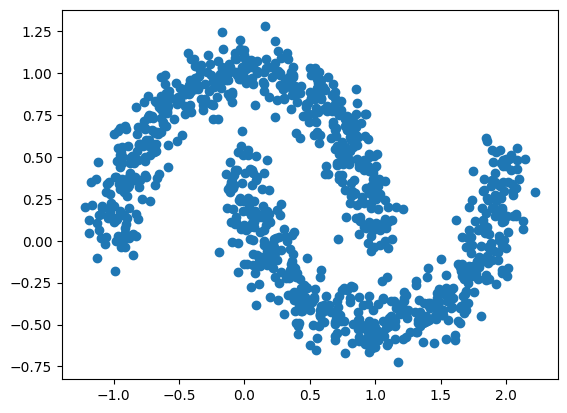

In [2]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T);

## MAF

In [16]:
num_layers = 5
hidden_features = 100
num_blocks = 2
activation = torch.relu

base_dist = StandardNormal(shape=[2])

transforms = []
transforms.append(PointwiseAffineTransform(shift=0., scale=1/6))
transforms.append(InverseTransform(Tanh()))
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MAF(
        features=2,
        hidden_features=hidden_features,
        num_blocks=num_blocks,
        activation=activation,
        ))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [17]:
num_iter = 1000
batch_size = 128
learning_rate = 1e-3

optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)
best_epoch = 0
best_loss = np.inf

for i in range(num_iter):
    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32).to(device)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if loss < best_loss:
        best_epoch = i
        best_loss = loss
        best_flow = copy.deepcopy(flow)
    
    print(i, float(loss))

0 9.06389331817627
1 8.597553253173828
2 8.108673095703125
3 7.585921764373779
4 7.032463550567627
5 6.44381046295166
6 5.8295111656188965
7 5.199759483337402
8 4.567343711853027
9 3.9580881595611572
10 3.4344544410705566
11 3.1624648571014404
12 3.0801262855529785
13 2.8630740642547607
14 2.705315351486206
15 2.367730140686035
16 2.035470962524414
17 1.9611026048660278
18 2.056373119354248
19 2.1982526779174805
20 2.0447919368743896
21 2.218841314315796
22 2.230229139328003
23 2.1028671264648438
24 1.9076719284057617
25 1.9065322875976562
26 1.920048475265503
27 1.8286405801773071
28 1.861005187034607
29 1.8711183071136475
30 1.884477138519287
31 1.859900951385498
32 1.8326929807662964
33 1.8943345546722412
34 1.8836424350738525
35 1.8146586418151855
36 1.8200420141220093
37 1.8004240989685059
38 1.768103837966919
39 1.7376446723937988
40 1.74843430519104
41 1.790165901184082
42 1.785935878753662
43 1.7745994329452515
44 1.7743569612503052
45 1.7561092376708984
46 1.7343056201934814
4

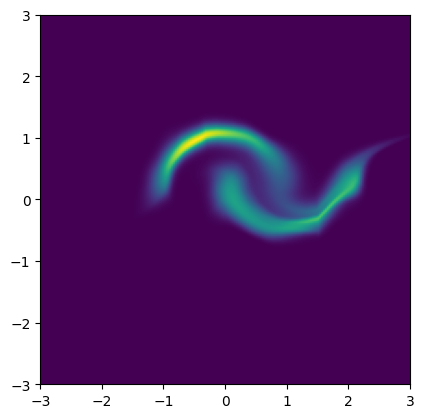

In [18]:
p = 3
n = 200
x = np.linspace(-p, p, n)
y = np.linspace(-p, p, n)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.concatenate(
    [xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1, dtype=np.float32,
    )
with torch.no_grad():
    zgrid = best_flow.log_prob(torch.tensor(xy)).exp().reshape(n, n)
plt.imshow(zgrid.numpy(), origin='lower', aspect='equal', extent=(-p, p, -p, p));

## RQ-NSF

### Autoregressive

In [19]:
num_layers = 5
hidden_features = 100
num_blocks = 2
activation = torch.relu
num_bins = 10
tails = 'linear'
tail_bound = 5.

base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(RQ_NSF_AR(
        features=2,
        hidden_features=hidden_features,
        num_blocks=num_blocks,
        activation=activation,
        num_bins=num_bins,
        tails=tails,
        tail_bound=tail_bound
        ))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [20]:
num_iter = 1000
batch_size = 128
learning_rate = 1e-3

optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)
best_epoch = 0
best_loss = np.inf

for i in range(num_iter):
    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32).to(device)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if loss < best_loss:
        best_epoch = i
        best_loss = loss
        best_flow = copy.deepcopy(flow)
    
    print(i, float(loss))

0 4.753793716430664
1 3.0559957027435303
2 3.6613171100616455
3 3.307997703552246
4 3.1930131912231445
5 2.9481515884399414
6 2.6499462127685547
7 2.640618324279785
8 2.354968547821045
9 2.3316009044647217
10 2.2761173248291016
11 2.141906499862671
12 2.085479974746704
13 1.9635162353515625
14 1.9574655294418335
15 1.9880406856536865
16 1.9934618473052979
17 2.357306480407715
18 1.81014084815979
19 2.035132646560669
20 1.976735234260559
21 1.8934381008148193
22 1.808617353439331
23 1.8400636911392212
24 1.8132450580596924
25 1.8290255069732666
26 1.8367499113082886
27 1.7812507152557373
28 1.7595369815826416
29 1.7802491188049316
30 1.5354382991790771
31 1.5670640468597412
32 1.712181568145752
33 1.6358205080032349
34 1.5704585313796997
35 1.5731664896011353
36 1.5330796241760254
37 1.5125560760498047
38 1.734786033630371
39 1.5169274806976318
40 1.5663974285125732
41 1.5779694318771362
42 1.5364470481872559
43 1.4092743396759033
44 1.5129146575927734
45 1.4661011695861816
46 1.3496276

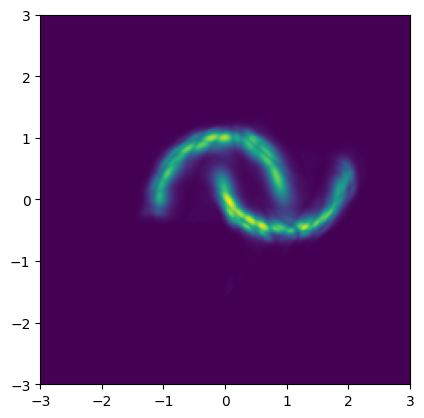

In [21]:
p = 3
n = 200
x = np.linspace(-p, p, n)
y = np.linspace(-p, p, n)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.concatenate(
    [xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1, dtype=np.float32,
    )
with torch.no_grad():
    zgrid = best_flow.log_prob(torch.tensor(xy)).exp().reshape(n, n)
plt.imshow(zgrid.numpy(), origin='lower', aspect='equal', extent=(-p, p, -p, p));

### Coupling

In [42]:
num_layers = 5
hidden_features = 100
num_blocks = 2
activation = torch.relu
num_bins = 5
tails = 'linear'
tail_bound = 5.

base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(RQ_NSF_C(
        mask=create_mid_split_binary_mask(2),
        transform_net_create_fn=lambda in_features, out_features: ResidualNet(
            in_features,
            out_features,
            hidden_features=hidden_features,
            context_features=None,
            num_blocks=num_blocks,
            activation=activation,
            dropout_probability=0.,
            use_batch_norm=False,
            ),
        num_bins=num_bins,
        tails=tails,
        tail_bound=tail_bound,
        # apply_unconditional_transform=False,
        # img_shape=None,
        # min_bin_width=splines.rational_quadratic.DEFAULT_MIN_BIN_WIDTH,
        # min_bin_height=splines.rational_quadratic.DEFAULT_MIN_BIN_HEIGHT,
        # min_derivative=splines.rational_quadratic.DEFAULT_MIN_DERIVATIVE,
        ))
    # transforms.append(BatchNorm(2))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist).to(device)

In [43]:
num_iter = 1000
batch_size = 128
learning_rate = 1e-3

optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)
best_epoch = 0
best_loss = np.inf

for i in range(num_iter):
    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32).to(device)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if loss < best_loss:
        best_epoch = i
        best_loss = loss
        best_flow = copy.deepcopy(flow)
    
    print(i, float(loss))

0 2.578981637954712
1 2.4158873558044434
2 2.2879998683929443
3 2.2472074031829834
4 2.1856470108032227
5 2.07590913772583
6 2.028696298599243
7 1.9575968980789185
8 1.9275745153427124
9 1.8669400215148926
10 1.8070285320281982
11 1.7975612878799438
12 1.6982742547988892
13 1.6569844484329224
14 1.5525116920471191
15 1.5742806196212769
16 1.5131770372390747
17 1.5065670013427734
18 1.4855682849884033
19 1.447585940361023
20 1.5321084260940552
21 1.4296257495880127
22 1.4332225322723389
23 1.4544192552566528
24 1.5034475326538086
25 1.4819879531860352
26 1.5723838806152344
27 1.4982117414474487
28 1.4723572731018066
29 1.3890626430511475
30 1.4483368396759033
31 1.3764442205429077
32 1.383049488067627
33 1.3826990127563477
34 1.3921313285827637
35 1.4340897798538208
36 1.3243242502212524
37 1.267448902130127
38 1.2898578643798828
39 1.3323038816452026
40 1.3345651626586914
41 1.3698885440826416
42 1.3818962574005127
43 1.279542326927185
44 1.3712694644927979
45 1.2817742824554443
46 1.2

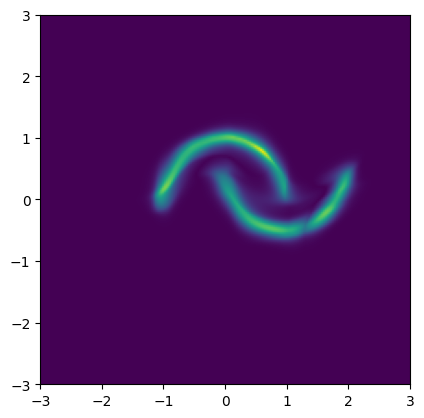

In [44]:
p = 3
n = 200
x = np.linspace(-p, p, n)
y = np.linspace(-p, p, n)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.concatenate(
    [xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1, dtype=np.float32,
    )
with torch.no_grad():
    zgrid = best_flow.log_prob(torch.tensor(xy)).exp().reshape(n, n)
plt.imshow(zgrid.numpy(), origin='lower', aspect='equal', extent=(-p, p, -p, p));